In [55]:
# Set up
import math
import pandas as pd
import numpy as np
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split
import tqdm

cmap_bold = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

In [40]:
# reading data
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [3]:
iris_df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
133,6.3,2.8,5.1,1.5,2.0
55,5.7,2.8,4.5,1.3,1.0
8,4.4,2.9,1.4,0.2,0.0
82,5.8,2.7,3.9,1.2,1.0
103,6.3,2.9,5.6,1.8,2.0


In [8]:
def KNN(train_X, train_Y, test_X, ks):
    """
    Compute predictions k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict of predictions for all k in ks
    """
    # Cats data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Efficient distance matrix computation
    # https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c   
    dists = -2 * np.dot(train_X, test_X.T) + np.sum(test_X**2, axis=1) + np.sum(train_X**2, axis=1)[:, np.newaxis]
    
    # find closest trainig points
    closest = np.argsort(dists, axis=0)
    
    # closest trainig points - > closest trainig targets
    targets = train_Y[closest]
  
    # Alloc space for results
    preds = {}
    
    for k in ks:
        predictions = scipy.stats.mode(targets[:k])[0] #take k closest targets
        predictions = predictions.ravel()
        preds[k] = predictions
  
    return preds

In [61]:
# divide data
train, test = train_test_split(iris_df, test_size=0.3333)

train_iris_x = np.array(train[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
train_iris_y = np.array(train['target'])

test_iris_x = np.array(test[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
test_iris_y = np.array(test['target'])

In [68]:
# run KNN
ks = np.arange(1,10,2)
predictions = KNN(train_iris_x, train_iris_y, test_iris_x, ks)

for k, preds in predictions.items():
    result = list(preds == test_iris_y)
    print(f'Score for k = {k} is: {result.count(True) / len(result) * 100}%')

Score for k = 1 is: 96.0%
Score for k = 3 is: 96.0%
Score for k = 5 is: 94.0%
Score for k = 7 is: 98.0%
Score for k = 9 is: 96.0%


# Plot the Decision boundary

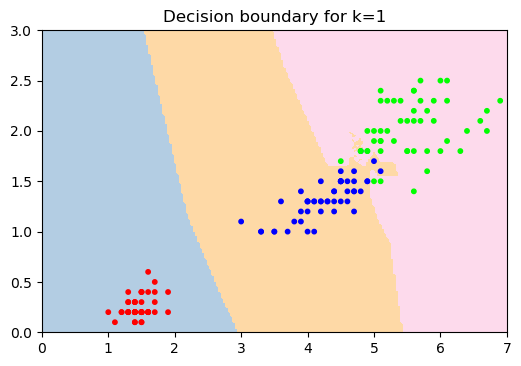

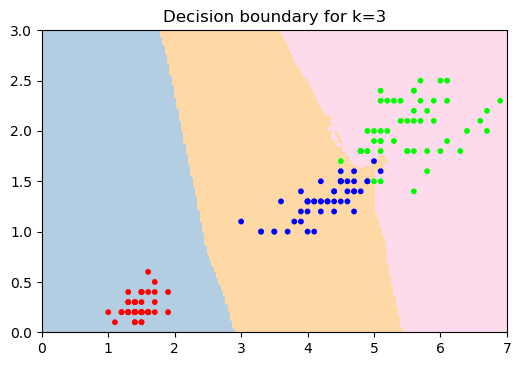

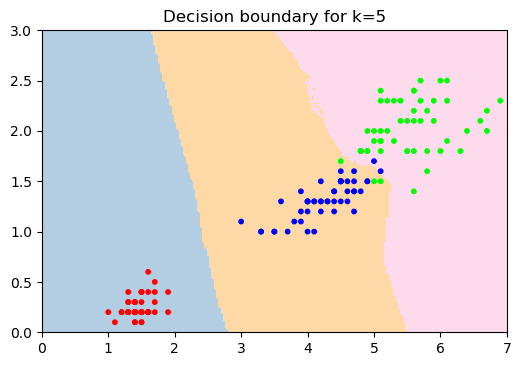

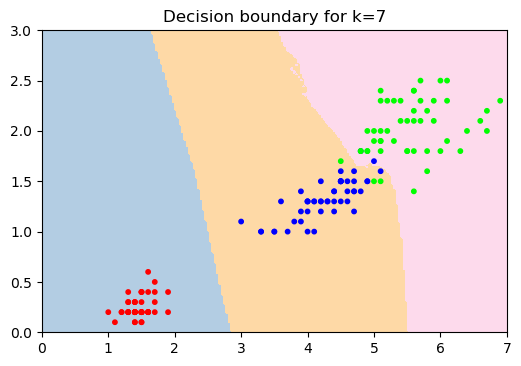

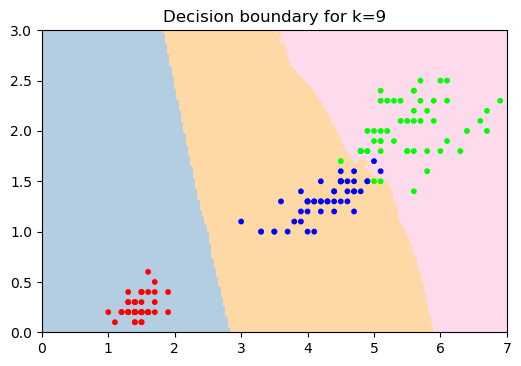

In [69]:
iris_x = np.array(iris_df[['petal length (cm)', 'petal width (cm)']])
iris_y = np.array(iris_df['target'])

X_space = np.linspace(0,7,200)
Y_space = np.linspace(0,3,200)
mesh_x, mesh_y = np.meshgrid(X_space, Y_space)

# use np.unique with suitable options to map the class names to numbers
target_names, iris_y_ids = np.unique(iris_y, return_inverse=True)
# print(target_names, iris_y_ids)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

preds = KNN(iris_x, iris_y_ids, mesh_data, ks)
for k, preds_k in preds.items():
    plt.figure(dpi=100)
    plt.title(f"Decision boundary for k={k}")
    plt.contourf(mesh_x, mesh_y, preds_k.reshape(200,200), levels=2, cmap='Pastel1')
    plt.scatter(iris_x[:,0], iris_x[:,1], c=iris_y_ids, s=10, cmap=cmap_bold)
      

# Estimate performance for various k

In [81]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in preds.items():
        assert(len(test_Y) == len(preds_k))
        ret[k] = np.sum(preds_k != test_Y) / test_Y.shape[0]
    return ret

In [82]:
iris_x = np.array(iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
iris_y = np.array(iris_df['target'])
N = len(iris_y)

ks = np.arange(1, 20, 2)
results = []

for _rep in tqdm.notebook.tqdm(range(1000)):
    train_idx, test_idx = np.split(np.random.permutation(N), [math.floor(N * 0.666)])

    preds = KNN(iris_x[train_idx], iris_y[train_idx], iris_x[test_idx], ks)
    errs = err_rates(preds, iris_y[test_idx])
    
    for k, errs_k in errs.items():
        results.append({'K':k, 'err_rate': errs_k})

# results_df will be a data_frame in long format
results_df = pd.DataFrame(results)

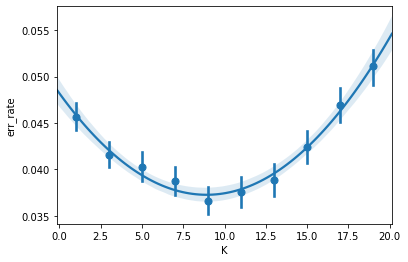

In [83]:
plt.figure()
sns.regplot(x=results_df.K, y=results_df.err_rate, data=results_df, x_estimator=np.mean, order=2)